In [31]:
!pip install google-cloud-storage

In [32]:
!pip install axolotl[ring-flash-attn]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 74.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [33]:
!pip install transformers huggingface_hub

In [34]:
!pip install  transformers datasets peft accelerate bitsandbytes wandb deepspeed

# Load Data

In [1]:
import json
from google.cloud import storage
import os

def save_json(data, filename):
    # Get the directory from the filename
    directory = os.path.dirname(filename)

    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the data to the file
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def list_files_in_bucket(bucket_name, prefix=""):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)

    # Print the list of file names in the bucket
    print("Files in the bucket:")
    for blob in blobs:
        print(blob.name)

def load_json_from_gcs(bucket_name, file_name):
    from google.cloud import storage
    import json

    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    if not file_name.endswith('.jsonl'):  # Ensure it's a JSONL file
        raise ValueError(f"The specified file '{file_name}' is not a JSONL file.")

    concatenated_data = []  # To accumulate JSON objects
    try:
        # Download and decode the file content
        content = blob.download_as_string().decode('utf-8')
        # Split content by lines and load each line as a separate JSON object
        for line in content.splitlines():
            if line.strip():  # Only parse non-empty lines
                json_obj = json.loads(line)
                concatenated_data.append(json_obj)  # Add JSON object to the list
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_name}: {e}")

    # Return the JSON as a string for output
    return json.dumps(concatenated_data, indent=4)  # Prettify the JSON output

def load_csv_from_gcs(bucket_name, file_name):
    from google.cloud import storage
    import pandas as pd
    from io import StringIO  # Corrected import for StringIO

    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    if not file_name.endswith('.csv'):  # Ensure it's a CSV file
        raise ValueError(f"The specified file '{file_name}' is not a CSV file.")

    try:
        # Download CSV content and load it into a pandas DataFrame
        content = blob.download_as_string().decode('utf-8')
        data = pd.read_csv(StringIO(content))  # Use StringIO to parse the CSV content
    except Exception as e:
        print(f"Error loading CSV file '{file_name}': {e}")
        return None

    return data


def save_csv_to_gcs(bucket_name, file_name, dataframe):
    from google.cloud import storage
    import pandas as pd

    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    if not file_name.endswith('.csv'):
        raise ValueError(f"The specified file '{file_name}' is not a CSV file.")

    try:
        # Convert the DataFrame to CSV and upload it to GCS
        csv_content = dataframe.to_csv(index=False)  # Convert DataFrame to CSV string
        blob.upload_from_string(csv_content, content_type='text/csv')
        print(f"File '{file_name}' successfully saved to bucket '{bucket_name}'.")
    except Exception as e:
        print(f"Error saving CSV file '{file_name}': {e}")

In [2]:
def stratified_sample(df, col1, col2, frac=0.5, random_state=None):
    total_samples = int(len(df) * frac)
    grouped = df.groupby([col1, col2])
    n_groups = len(grouped)
    samples_per_group = total_samples // n_groups

    sampled_df = (
        grouped
        .apply(lambda x: x.sample(n=min(samples_per_group, len(x)), random_state=random_state))
        .reset_index(drop=True)
    )
    return sampled_df

In [34]:
train_data = load_csv_from_gcs("mddi-reach-conversation", "mistral_training_data/mistral_train.csv")
augmented_full_df = load_csv_from_gcs("mddi-reach-conversation", "mistral_training_data/augmented_mistral_train.csv")
test_data = load_csv_from_gcs("mddi-reach-conversation", "mistral_training_data/mistral_test.csv").rename({'key_point': 'stance', 'person_id': 'user'}, axis=1)
vali_data = load_csv_from_gcs("mddi-reach-conversation", "mistral_training_data/mistral_val.csv")
vali_data['prompt'] = vali_data[['prompt', 'label']].apply(lambda x: x[0] + str(x[1]) + "</s>", axis=1)

train_data.tail()

<ipython-input-34-8847c0ea2598>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vali_data['prompt'] = vali_data[['prompt', 'label']].apply(lambda x: x[0] + str(x[1]) + "</s>", axis=1)


,group,user,stance,topic_group,human_label,agreement,group_user,label,pid,chat_group_id,contributor,topic,content_concat,prompt
2435,6,dd88a7a7-de66-4503-bfee-dfc0e74f578f,Contributor shared varying perspectives on whe...,rideout,no opinion,unanimous,6dd88a7a7-de66-4503-bfee-dfc0e74f578f,0,dd88a7a7-de66-4503-bfee-dfc0e74f578f,6,16,"📢 *Topic* 📢\n\nIn Parliament today (3 July), S...",Contributor255: https://www.channelnewsasia.co...,<s>[INST]Determine whether Contributor16 holds...
2436,6,dd88a7a7-de66-4503-bfee-dfc0e74f578f,Contributor had differing opinions on whether ...,rideout,no opinion,unanimous,6dd88a7a7-de66-4503-bfee-dfc0e74f578f,0,dd88a7a7-de66-4503-bfee-dfc0e74f578f,6,16,"📢 *Topic* 📢\n\nIn Parliament today (3 July), S...",Contributor255: https://www.channelnewsasia.co...,<s>[INST]Determine whether Contributor16 holds...
2437,6,dd88a7a7-de66-4503-bfee-dfc0e74f578f,Contributor expressed different views on the t...,rideout,no opinion,unanimous,6dd88a7a7-de66-4503-bfee-dfc0e74f578f,0,dd88a7a7-de66-4503-bfee-dfc0e74f578f,6,16,"📢 *Topic* 📢\n\nIn Parliament today (3 July), S...",Contributor255: https://www.channelnewsasia.co...,<s>[INST]Determine whether Contributor16 holds...
2438,6,dd88a7a7-de66-4503-bfee-dfc0e74f578f,Contributor shared differing opinions on wheth...,rideout,no opinion,unanimous,6dd88a7a7-de66-4503-bfee-dfc0e74f578f,0,dd88a7a7-de66-4503-bfee-dfc0e74f578f,6,16,"📢 *Topic* 📢\n\nIn Parliament today (3 July), S...",Contributor255: https://www.channelnewsasia.co...,<s>[INST]Determine whether Contributor16 holds...
2439,6,dd88a7a7-de66-4503-bfee-dfc0e74f578f,Contributor shared differing views on the inde...,rideout,no opinion,unanimous,6dd88a7a7-de66-4503-bfee-dfc0e74f578f,0,dd88a7a7-de66-4503-bfee-dfc0e74f578f,6,16,"📢 *Topic* 📢\n\nIn Parliament today (3 July), S...",Contributor255: https://www.channelnewsasia.co...,<s>[INST]Determine whether Contributor16 holds...


In [35]:
list(train_data.prompt.values)[-2]

"<s>[INST]Determine whether Contributor16 holds the same view as this statement: 'Contributor shared differing opinions on whether the Singapore Land Authority (SLA) should rent out more colonial properties.’? Based on the following conversation summary, respond with ‘1’ if they share the view, or ‘0’ otherwise. Even if it is implicit, consider it a match. Do not include any additional text. The following are messages by contributor 16 and other contributors: \n Contributor255: https://www.channelnewsasia.com/singapore/ridout-road-properties-officers-privileged-information-declaration-renting-government-sm-teo-3602056?cid=internal_sharetool_iphone_03072023_cnaThis directly address Point 2 for me that there are gaps and as such , the integrity is left in a question mark here for the 2 ministers instead of it being iron clad there was none .\nContributor813: For a second point, why should the ministers not have bought their own private properties elsewhere to stay in, if the primary moti

In [36]:
list(augmented_full_df.prompt.values)[-2]

"<s>[INST]Determine whether Contributor316 holds the same view as this statement: 'Contributors expressed strong support for the implementation of a national coding curriculum in primary schools, emphasizing the need to equip students with essential digital skills from an early age, while also suggesting that additional resources be allocated for teacher training in this area.’? Based on the following conversation summary, respond with ‘1’ if they share the view, or ‘0’ otherwise. Even if it is implicit, consider it a match. Do not include any additional text. The following are messages by contributor 316 and other contributors: \n Contributor166: Theres a risk that increasing financial assistance may lead to a dependence on government support rather than empowering families to improve their situations.\nContributor567: Isnt it fascinating how some believe that financial assistance alone can solve systemic issues? Perhaps there are deeper-rooted challenges that need addressing beyond i

In [16]:
list(test_data.prompt.values)[-2]

'<s>[INST]Determine whether Contributor234 holds the same view as this statement: \'Contributors discussed the importance of having diverse voices in parliament and the role of opposition parties in representing different viewpoints.’? Based on the following conversation summary, respond with ‘1’ if they share the view, or ‘0’ otherwise. Even if it is implicit, consider it a match. Do not include any additional text. The following are messages by contributor 234 and other contributors: \n Contributor2132: like breaking up opposition strongholds. Some sections in Marine Parade and East Coast GRC and Tampines also have shown pretty strong opposition support.\nContributor1463: Wow.....you guys seem to know everything. How many people live where, what kind of people they are, who they will vote for, etc etc etc. So much so that you all can draw conclusions with such certainty just by looking at the boundaries. If you all are not political consultants by now, it would be such a waste of loc

In [17]:
print(test_data.shape)

(1349, 12)


In [37]:
augmented_full_df_sampled = stratified_sample(augmented_full_df, 'stance', 'human_label', frac=0.30, random_state=42)
augmented_full_df_sampled.shape

<ipython-input-2-89bc82edf383>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(samples_per_group, len(x)), random_state=random_state))


(9082, 7)

In [38]:
stratified_test = test_data.copy().sample(frac=0.7)[[ 'stance', 'prompt', 'label']].reset_index(drop=True)
stratified_test["prompt"] = stratified_test[["prompt", "label"]].apply(lambda x: x[0] + str(x[1]) + "</s>", axis=1)
print(stratified_test.prompt.loc[0][-20:])
print(stratified_test.shape)
list(stratified_test.prompt.values)[0][-5:]

nology. [/INST]0</s>
(944, 3)


<ipython-input-38-9683cd3b886e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stratified_test["prompt"] = stratified_test[["prompt", "label"]].apply(lambda x: x[0] + str(x[1]) + "</s>", axis=1)


'0</s>'

In [41]:
import pandas as pd
df = pd.concat([
    train_data[['chat_group_id', 'label', 'stance', 'prompt', 'human_label', 'topic_group', 'agreement', 'user', 'group_user', 'topic']],
    #augmented_full_df[['chat_group_id',  'stance', 'content', 'class', 'context', 'human_label']].rename({'class': 'label'}, axis=1),
    augmented_full_df_sampled[[  'stance', 'prompt', 'label']],
    stratified_test
    ]
).reset_index(drop=True)

#df = train_data[['chat_group_id', 'label', 'stance', 'prompt', 'human_label', 'topic_group', 'agreement', 'user', 'group_user', 'topic']].loc[:100]
df.head(2)

,chat_group_id,label,stance,prompt,human_label,topic_group,agreement,user,group_user,topic
0,1.0,0,Contributor shared different perspectives on p...,<s>[INST]Determine whether Contributor429 hold...,no opinion,national_day,unanimous,04195570-f8b3-4eab-866f-32808d77d8e1,104195570-f8b3-4eab-866f-32808d77d8e1,"*📢 Topic 📢*\nIn his National Day Message, Prim..."
1,1.0,0,Contributor expressed differing levels of trus...,<s>[INST]Determine whether Contributor429 hold...,disagree,national_day,majority,04195570-f8b3-4eab-866f-32808d77d8e1,104195570-f8b3-4eab-866f-32808d77d8e1,"*📢 Topic 📢*\nIn his National Day Message, Prim..."


In [42]:
import json

def mistral_to_chat(entry):
    entry = entry.strip()

    # Check if entry starts with <s>[INST] and ends with </s>
    if not entry.startswith("<s>[INST]") or not entry.endswith("</s>"):
        print("Skipped (bad format):", entry)
        return None

    messages = []
    while True:
        # Look for the next [INST] ... [/INST] ... </s> block
        inst_start = entry.find("[INST]")
        inst_end = entry.find("[/INST]")
        s_end = entry.find("</s>", inst_end)

        if inst_start == -1 or inst_end == -1 or s_end == -1:
            break

        instruction = entry[inst_start + len("[INST]"):inst_end].strip()
        output = entry[inst_end + len("[/INST]"):s_end].strip()

        if instruction:
            messages.append({"role": "user", "content": instruction})
        if output:
            messages.append({"role": "assistant", "content": output})

        # Move to the next segment
        entry = entry[s_end + len("</s>"):].strip()

    if not messages:
        return None

    return {"messages": messages}


def convert_list_to_jsonl(entries, output_path):
    with open(output_path, "w", encoding="utf-8") as outfile:
        for entry in entries:
            chat_format = mistral_to_chat(entry)
            if chat_format:
                json.dump(chat_format, outfile, ensure_ascii=False)
                outfile.write("\n")
train_prompts = list(df.prompt.values)

convert_list_to_jsonl(train_prompts, "train_data.jsonl")


In [43]:
import re
import json
'''

def save_prompts_to_jsonl(df, output_file):
    """
    Save the 'prompt' column of a DataFrame to a JSONL file.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'prompt' column.
        output_file (str): The path to the output .jsonl file.
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for prompt in df["prompt"]:
            json_line = json.dumps({"prompt": prompt}, ensure_ascii=False)
            f.write(json_line + "\n")



train_fp = "/content/train_data.jsonl"
save_prompts_to_jsonl(df, train_fp)
val_fp = "/content/val_data.jsonl"
save_prompts_to_jsonl(vali_data, val_fp)

def mistral_to_alpaca(entry):
    # Strip any leading/trailing whitespace
    entry = entry.strip()

    # Find the position of the [INST] and [/INST] tags
    inst_start = entry.find("[INST]") + len("[INST]")
    inst_end = entry.find("[/INST]")

    # Find the position of <s> and </s> tags
    s_start = entry.find("<s>") + len("<s>")
    s_end = entry.find("</s>")

    if inst_start != -1 and inst_end != -1 and s_start != -1 and s_end != -1:
        # Extract the instruction and output, without the tags
        instruction = entry[inst_start:inst_end].strip()
        output = entry[inst_end:s_end].strip()  # Output is between [/INST] and </s>

        # Clean the instruction and output by removing the surrounding tags
        instruction = instruction.replace('[INST]', '').replace('[/INST]', '').replace('<s>', '').replace('</s>', '').strip()
        output = output.replace('<s>', '').replace('</s>', '').replace('[INST]', '').replace('[/INST]', '').strip()
        if len(output) ==0:
            print(output)
        return {
            "instruction": instruction,
            "output": output
        }
    print(entry)
    return None


def mistral_to_alpaca(entry):
    # Strip any leading/trailing whitespace
    entry = entry.strip()

    # Find the position of the [INST] and [/INST] tags
    inst_start = entry.find("[INST]") + len("[INST]")
    inst_end = entry.find("[/INST]")

    # Find the position of <s> and </s> tags
    s_start = entry.find("<s>") + len("<s>")
    s_end = entry.find("</s>")

    if inst_start != -1 and inst_end != -1 and s_start != -1 and s_end != -1:
        # Extract the instruction and output, without the tags
        instruction = entry[inst_start:inst_end].strip()
        output = entry[inst_end:s_end].strip()  # Output is between [/INST] and </s>

        # Clean the instruction and output by removing the surrounding tags
        instruction = instruction.replace('[INST]', '').replace('[/INST]', '').replace('<s>', '').replace('</s>', '').strip()
        output = output.replace('<s>', '').replace('</s>', '').replace('[INST]', '').replace('[/INST]', '').strip()

        # Prepare the output in the required chat template format
        return [
            {"role": "user", "content": instruction},
            {"role": "assistant", "content": output},
        ]
    print(entry)
    return None
def save_to_jsonl(train_prompts, output_file='train_data.jsonl'):
    train_data = []
    for entry in train_prompts:
        alpaca = mistral_to_alpaca(entry)
        if alpaca:
            train_data.append(alpaca)

    # Write each entry in train_data as a separate JSON object on a new line
    with open(output_file, 'w') as f:
        for entry in train_data:
            f.write(json.dumps(entry) + '\n')  # Ensuring each entry is written as an object on a new line
train_prompts = list(df.prompt.values)
val_prompts = list(vali_data.prompt.values)

save_to_jsonl(train_prompts, "/content/train_data.jsonl")
save_to_jsonl(val_prompts, "/content/val_data.jsonl")
'''

# # Format train data into a variable first
# train_data = []
# for entry in train_prompts:
#     alpaca = mistral_to_alpaca(entry)
#     if alpaca:
#         train_data.append(alpaca)

# # Save train data as JSONL
# with open("/content/train_data.jsonl", "w") as f:
#     for entry in train_data:
#         f.write(json.dumps(entry, ensure_ascii=False) + "\n")

# # Format validation data into a variable first
# val_data = []
# for entry in val_prompts:
#     alpaca = mistral_to_alpaca(entry)
#     if alpaca:
#         val_data.append(alpaca)


# # Save validation data as JSONL
# with open("/content/val_data.jsonl", "w") as f:
#     for entry in val_data:
#         f.write(json.dumps(entry, ensure_ascii=False) + "\n")



'\n\ndef save_prompts_to_jsonl(df, output_file):\n    """\n    Save the \'prompt\' column of a DataFrame to a JSONL file.\n\n    Args:\n        df (pd.DataFrame): The DataFrame containing the \'prompt\' column.\n        output_file (str): The path to the output .jsonl file.\n    """\n    with open(output_file, "w", encoding="utf-8") as f:\n        for prompt in df["prompt"]:\n            json_line = json.dumps({"prompt": prompt}, ensure_ascii=False)\n            f.write(json_line + "\n")\n\n\n\ntrain_fp = "/content/train_data.jsonl"\nsave_prompts_to_jsonl(df, train_fp)\nval_fp = "/content/val_data.jsonl"\nsave_prompts_to_jsonl(vali_data, val_fp)\n\ndef mistral_to_alpaca(entry):\n    # Strip any leading/trailing whitespace\n    entry = entry.strip()\n\n    # Find the position of the [INST] and [/INST] tags\n    inst_start = entry.find("[INST]") + len("[INST]")\n    inst_end = entry.find("[/INST]")\n\n    # Find the position of <s> and </s> tags\n    s_start = entry.find("<s>") + len("<s

In [17]:
print(len(df))
df.prompt.str.len().describe()

4723


,prompt
count,4723.000000
mean,5521.282448
std,3876.896382
min,518.000000
25%,2020.000000
50%,2944.000000
75%,8551.000000
max,17635.000000


# Fine-tuning

In [44]:
%%writefile /content/config.yml
# File: /content/config.yml

base_model: mistralai/Mistral-7B-Instruct-v0.2

datasets:
  - path: /content/train_data.jsonl
    ds_type: json
    type: chat_template
    chat_template: tokenizer_default
    field_messages: messages
    message_property_mappings:
      role: role
      content: content
    roles:
      user: ["user"]
      assistant: ["assistant"]
    drop_system_message: true
    roles_to_train: ["assistant"]
    data_files:
      - /content/train_data.jsonl

# test_datasets:
#   - path: /content/val_data.jsonl
#     ds_type: json
#     type:
#       type: chat_template
#       chat_template: tokenizer_default
#     data_files:
#       - /content/val_data.jsonl
#     split: train

dataset_processes: 1

# Output
output_dir: /content/mistral-output

# LoRA config
adapter: lora
lora_r: 8
lora_alpha: 16
lora_dropout: 0.1
lora_target_modules:
  - q_proj
  - k_proj
  - v_proj
  #- o_proj
  #- gate_proj
  #- up_proj
  #- down_proj
lora_modules_to_save:
  - embed_tokens
  - lm_head
is_mistral_derived_model: true

# Format
model_type: AutoModelForCausalLM
tokenizer_type: AutoTokenizer
sequence_len: 8192
pad_to_sequence_len: true
#load_in_8bit: true
load_in_4bit: true

flash_attention: true
sequence_parallel_degree: 2
device_map: sequential

# Training
num_epochs: 1
micro_batch_size: 1
gradient_accumulation_steps: 8

# Optimization
learning_rate: 2e-4
lr_scheduler_type: cosine
#weight_decay: 0.001

#Validation
# evaluation_strategy: steps
# #early_stopping_patience: 3
# do_causal_lm_eval: false
# eval_causal_lm_metrics:
#   - sacrebleu
#   - ter
#   - perplexity
# eval_sample_packing: false
# eval_max_new_tokens: 9
# eval_batch_size: 1
# eval_steps: 1000
# logging_steps: 1000

save_steps: 200

# Precision
bf16: true

# Trainer
trainer: AxolotlTrainer

# DeepSpeed
#deepspeed: /content/ds_config_zero3.json

# Wandb
wandb_mode: online
wandb_project: reach-fine-tuning
wandb_name: v15
wandb_run_id: v15
wandb_log_model: end


Overwriting /content/config.yml


In [45]:
%%writefile /content/ds_config_zero3.json
{
  "train_batch_size": 16,
  "train_micro_batch_size_per_gpu": 1,
  "gradient_accumulation_steps": 8,
  "zero_optimization": {
    "stage": 3,
    "offload_optimizer": {
      "device": "cpu"
    },
    "offload_param": {
      "device": "cpu"
    },
    "overlap_comm": true,
    "contiguous_gradients": true
  },
  "bf16": {
    "enabled": true
  },
  "steps_per_print": 100,
  "wall_clock_breakdown": false
}


Overwriting /content/ds_config_zero3.json


In [46]:
import torch
# Create a tensor and move it to GPU
x = torch.randn(1, 1, device='cuda')

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Ensure a GPU is installed and configured.")

# Check the available and total memory on the GPU
allocated_memory = torch.cuda.memory_allocated()  # Memory currently in use
reserved_memory = torch.cuda.memory_reserved()  # Memory reserved by the allocator
free_memory = torch.cuda.memory_reserved() - torch.cuda.memory_allocated()  # Free memory

print(f"Allocated Memory: {allocated_memory / 1024 ** 2:.2f} MB")
print(f"Reserved Memory: {reserved_memory / 1024 ** 2:.2f} MB")
print(f"Free Memory: {free_memory / 1024 ** 2:.2f} MB")

CUDA is available! Using GPU: NVIDIA A100-SXM4-40GB
Allocated Memory: 794.82 MB
Reserved Memory: 1186.00 MB
Free Memory: 391.18 MB


In [ ]:
import os

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Now, import PyTorch
import torch

# You can now use PyTorch as usual
print(torch.cuda.is_available())  # Check if CUDA is available

True


In [20]:
from huggingface_hub import login

login()

In [21]:
!wandb login

wandb: Currently logged in as: wilson_ng (wilson_ng-govtech). Use `wandb login --relogin` to force relogin


In [ ]:
!nvidia-smi nvlink --status


GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-a82dd269-9d2e-6d13-818f-001427bc2793)
	 Link 0: 25 GB/s
	 Link 1: 25 GB/s
	 Link 2: 25 GB/s
	 Link 3: 25 GB/s
	 Link 4: 25 GB/s
	 Link 5: 25 GB/s
	 Link 6: 25 GB/s
	 Link 7: 25 GB/s
	 Link 8: 25 GB/s
	 Link 9: 25 GB/s
	 Link 10: 25 GB/s
	 Link 11: 25 GB/s
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-d14257b2-2da5-0825-6052-9757a3ba708b)
	 Link 0: 25 GB/s
	 Link 1: 25 GB/s
	 Link 2: 25 GB/s
	 Link 3: 25 GB/s
	 Link 4: 25 GB/s
	 Link 5: 25 GB/s
	 Link 6: 25 GB/s
	 Link 7: 25 GB/s
	 Link 8: 25 GB/s
	 Link 9: 25 GB/s
	 Link 10: 25 GB/s
	 Link 11: 25 GB/s


In [ ]:
!export NCCL_P2P_LEVEL=NVL

In [47]:
!rm -rf /content/mistral-output*
!rm -rf /content/wandb*
!rm -rf /content/last_run_prepared*

In [ ]:
import os
print(os.path.exists('/content/train_data.jsonl'))  # Should return True
print(os.path.exists('/content/val_data.jsonl'))    # Should return True
print(os.path.exists('/content/ds_config_zero3.json'))
print(os.path.exists('/content/config.yml'))

In [48]:
!accelerate launch --multi_gpu -m axolotl.cli.train /content/config.yml

	`--num_processes` was set to a value of `4`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-04-28 09:56:07.156743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 09:56:07.178139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 09:56:07.184641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 09:56:07.225305: E external/local_xla/xla/stream_executor/cuda

In [ ]:
"""
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

model.to("cuda")

model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_config)

training_args = TrainingArguments(
    output_dir="/content/outputs/mistral-qlora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    evaluation_strategy="steps",  # eval every few steps
    eval_steps=20,                # eval every 20 steps
    logging_steps=5,              # log training loss every 5 steps
    save_strategy="steps",
    save_steps=50,                # save model every 50 steps
    learning_rate=2e-4,
    lr_scheduler_type="cosine",   # Cosine decay for LR
    warmup_ratio=0.1,             # 10% warm-up
    bf16=True,
    report_to="wandb",            # Track with WandB
    run_name="mistral-finetune",
    logging_dir="./logs",         # For tracking logs
)

# Step 5: Data Collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Step 6: Early Stopping Callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2  # stop if eval loss doesn't improve for 2 evals
)

# Step 7: Compute Perplexity
def compute_metrics(eval_preds):
    loss = eval_preds["loss"] if isinstance(eval_preds, dict) else eval_preds.loss
    perplexity = math.exp(loss)
    return {"eval_loss": loss, "perplexity": perplexity}

# Step 8: Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # Add early stopping
)

# Step 9: Train the Model
trainer.train()
"""

In [49]:
# Save Model artifact to gcs
!gsutil -m rm -r gs://mddi-reach-conversation/mistral-output/
!gsutil -m cp -r /content/mistral-output/ gs://mddi-reach-conversation/

Removing gs://mddi-reach-conversation/mistral-output/README.md#1745832339847600...
Removing gs://mddi-reach-conversation/mistral-output/adapter_config.json#1745832339799423...
Removing gs://mddi-reach-conversation/mistral-output/adapter_model.safetensors#1745832364443992...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/README.md#1745832340147711...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/adapter_config.json#1745832339769123...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/adapter_model.safetensors#1745832364285822...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/optimizer.pt#1745832388044395...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/rng_state_0.pth#1745832339790699...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/rng_state_1.pth#1745832340137383...
Removing gs://mddi-reach-conversation/mistral-output/checkpoint-200/rng_state_2.pth#174583234098

## Testing

In [50]:
test_data = load_csv_from_gcs("mddi-reach-conversation", "mistral_training_data/mistral_test.csv").rename({'key_point': 'stance', 'person_id': 'user'}, axis=1)
#train_data = load_csv_from_gcs("mddi-reach-conversation", "mistral_training_data/mistral_train.csv").rename({'key_point': 'stance', 'person_id': 'user'}, axis=1)

In [ ]:
#!gsutil -m cp -r gs://mddi-reach-conversation/mistral-output/ /content/

Copying gs://mddi-reach-conversation/mistral-output/README.md...
Copying gs://mddi-reach-conversation/mistral-output/adapter_config.json...
Copying gs://mddi-reach-conversation/mistral-output/adapter_model.safetensors...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://mddi-reach-conversation/mistral-output/checkpoint-1000/adapter_config.json...
Copying gs://mddi-reach-conversation/mistral-output/checkpoint-1000/README.md...
Copying gs://mddi-reach-conversation/mistral-output/checkpoint-1000/adapter_model.safetensors...
Copying gs://mddi-reach-conversation/mistral-output/checkpoint-1000/optimizer.pt...
Copying gs://mddi-reach-conversation/mistral-output/checkpoint-1000/rng_state_0.pth...
Copying gs://mddi-reach-conversation/mistral-output/checkpoint-1000/rng_state_1.pth...
Copying

In [51]:
# Load Model
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer,  BitsAndBytesConfig
import torch
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
# Define 4-bit quantization config (must match training time)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load base model in 4-bit
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    padding_side="left",
    #max_length=8192,padding='max_length'
    #add_eos_token=True,
    #add_bos_token=True
)
#tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [52]:
# Load fine-tuned PEFT adapter
model = PeftModel.from_pretrained(base_model, "/content/mistral-output")

# Merge LoRA weights into base model
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [53]:
for name, param in model.named_parameters():
    print(f"{name}")

base_model.model.model.embed_tokens.weight
base_model.model.model.layers.0.self_attn.q_proj.weight
base_model.model.model.layers.0.self_attn.k_proj.weight
base_model.model.model.layers.0.self_attn.v_proj.weight
base_model.model.model.layers.0.self_attn.o_proj.weight
base_model.model.model.layers.0.mlp.gate_proj.weight
base_model.model.model.layers.0.mlp.up_proj.weight
base_model.model.model.layers.0.mlp.down_proj.weight
base_model.model.model.layers.0.input_layernorm.weight
base_model.model.model.layers.0.post_attention_layernorm.weight
base_model.model.model.layers.1.self_attn.q_proj.weight
base_model.model.model.layers.1.self_attn.k_proj.weight
base_model.model.model.layers.1.self_attn.v_proj.weight
base_model.model.model.layers.1.self_attn.o_proj.weight
base_model.model.model.layers.1.mlp.gate_proj.weight
base_model.model.model.layers.1.mlp.up_proj.weight
base_model.model.model.layers.1.mlp.down_proj.weight
base_model.model.model.layers.1.input_layernorm.weight
base_model.model.mode

In [54]:

input_text = list(test_data.prompt.values)[10]

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to("cuda")

# Generate text
output = merged_model.generate(inputs["input_ids"], attention_mask=inputs['attention_mask'], pad_token_id=tokenizer.pad_token_id)

# Decode the generated text
generated_text = tokenizer.decode(output[0])

# Print the generated text
print(generated_text.split("[/INST]")[-1], list(test_data.label.values)[10])

 1</s> 0


In [29]:
import warnings
from transformers import logging

# Suppress the specific warning
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`")

# Alternatively, set logging to error level to suppress other warnings
logging.set_verbosity_error()


In [55]:
# Format Test Data
from tqdm import tqdm
all_predictions = []
for test_prompt in tqdm(list(test_data.prompt.values)):
    # Tokenize the input text
    inputs = tokenizer(test_prompt, return_tensors="pt", truncation=True).to("cuda")

    # Generate text
    output = merged_model.generate(inputs["input_ids"], attention_mask=inputs['attention_mask'], pad_token_id=tokenizer.pad_token_id)

    # Decode the generated text
    generated_text = tokenizer.decode(output[0] )
    generated_text_cleaned = generated_text.split("[/INST]")[-1]
    if "1" in generated_text_cleaned:
        prediction = 1
    elif "0" in generated_text_cleaned:
        prediction = 0
    else:
        prediction = -1
    all_predictions.append(prediction)
test_data["pred"] = all_predictions


100%|██████████| 1349/1349 [14:16<00:00,  1.58it/s]


In [31]:
print(f"Percentage of incorrectly parsed output: {len(test_data[test_data['pred'] == -1])/len(test_data)}")

Percentage of incorrectly parsed output: 0.0


In [56]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    auc,
    accuracy_score
)

# Metrics calculation
def compute_metrics(true_labels, prediction):
    metrics = {}
    metrics["accuracy"] = accuracy_score(true_labels, prediction)
    metrics["f1"] = f1_score(true_labels, prediction)
    metrics["precision"] = precision_score(true_labels, prediction)
    metrics["recall"] = recall_score(true_labels, prediction)
    metrics["f1_weighted"] = f1_score(true_labels, prediction, average = "weighted")
    metrics["recall_weighted"] = recall_score(true_labels,prediction, average = "weighted")
    metrics["precision_weighted"] = precision_score(true_labels, prediction, average = "weighted")
    metrics["f1_marco"] = f1_score(true_labels, prediction, average = "macro")
    metrics["precision_marco"] = precision_score(true_labels, prediction, average = "macro")
    metrics["recall_marco"] = recall_score(true_labels, prediction, average = "macro")

    return metrics

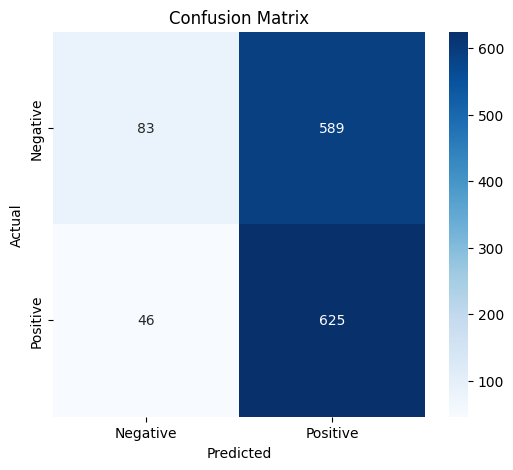

{'accuracy': 0.5271779597915115,
 'f1': 0.6631299734748011,
 'precision': 0.514827018121911,
 'recall': 0.9314456035767511,
 'f1_weighted': 0.4350157332871093,
 'recall_weighted': 0.5271779597915115,
 'precision_weighted': 0.5791668072844811,
 'f1_marco': 0.4351854611443918,
 'precision_marco': 0.5791189354175447,
 'recall_marco': 0.527478754169328}

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

pred_to_evaluate = test_data[test_data["pred"]!=-1]

# Compute confusion matrix
cm = confusion_matrix(list(pred_to_evaluate["label"].values), list(pred_to_evaluate["pred"].values))
labels = ['Negative', 'Positive']  # Change based on your label semantics

# Display as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
compute_metrics(list(pred_to_evaluate["label"].values), list(pred_to_evaluate["pred"].values))


## Base Model Evaluation

In [ ]:
# Base Model evaluation
# Load base model in 4-bit
from tqdm import tqdm

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

all_base_predictions = []
for test_prompt in tqdm(list(test_data.prompt.values)):
    # Tokenize the input text
    inputs = tokenizer(test_prompt, return_tensors="pt").to("cuda")

    # Generate text
    output = base_model.generate(inputs['input_ids'])

    # Decode the generated text
    generated_text = tokenizer.decode(output[0])
    generated_text_cleaned = generated_text.split("[/INST]")[-1]
    if "1" in generated_text_cleaned:
        prediction = 1
    elif "0" in generated_text_cleaned:
        prediction = 0
    else:
        prediction = -1
    all_base_predictions.append(prediction)
test_data["base_pred"] = all_base_predictions

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1349/1349 [23:06<00:00,  1.03s/it]


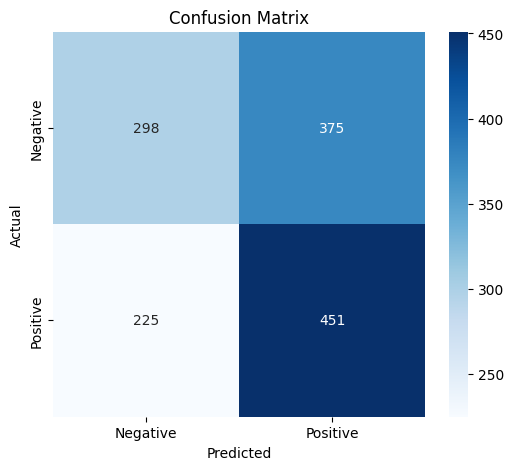

{'accuracy': 0.5552260934025204,
 'f1': 0.6005326231691078,
 'precision': 0.5460048426150121,
 'recall': 0.6671597633136095,
 'f1_weighted': 0.5495438363247711,
 'recall_weighted': 0.5552260934025204,
 'precision_weighted': 0.5578708116016146,
 'f1_marco': 0.5494301911832161,
 'precision_marco': 0.5578972587836055,
 'recall_marco': 0.5549766127117824}

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
pred_to_evaluate = test_data[test_data["base_pred"]!=-1]


# Compute confusion matrix
cm = confusion_matrix(list(pred_to_evaluate["label"].values), list(pred_to_evaluate["base_pred"].values))
labels = ['Negative', 'Positive']  # Change based on your label semantics

# Display as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

compute_metrics(pred_to_evaluate["label"], pred_to_evaluate["base_pred"])


In [ ]:
from tqdm import tqdm

all_base_predictions = []
for train_prompt in tqdm(list(train_data.prompt.values)):
    # Tokenize the input text
    inputs = tokenizer(train_prompt.split("[/INST]")[0], return_tensors="pt").to("cuda")

    # Generate text
    output = base_model.generate(inputs['input_ids'], pad_token_id=tokenizer.pad_token_id)

    # Decode the generated text
    generated_text = tokenizer.decode(output[0])
    generated_text_cleaned = generated_text.split("[/INST]")[-1]
    if "1" in generated_text_cleaned:
        prediction = 1
    elif "0" in generated_text_cleaned:
        prediction = 0
    else:
        prediction = -1
    all_base_predictions.append(prediction)
train_data["base_pred"] = all_base_predictions

100%|██████████| 2440/2440 [58:26<00:00,  1.44s/it]


In [ ]:

pred_to_evaluate = train_data[train_data["base_pred"]!=-1]
print(len(train_data), len(pred_to_evaluate))
compute_metrics(pred_to_evaluate["label"], pred_to_evaluate["base_pred"])

2440 2440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.06885245901639345,
 'f1': 0.12883435582822086,
 'precision': 0.06885245901639345,
 'recall': 1.0,
 'f1_weighted': 0.008870562204566026,
 'recall_weighted': 0.06885245901639345,
 'precision_weighted': 0.004740661112604139,
 'f1_marco': 0.06441717791411043,
 'precision_marco': 0.03442622950819672,
 'recall_marco': 0.5}